# Cats vs Dogs

Az alábbiakban bináris klasszifikátort készítünk, ahol kutyák és macskák képek alapján történő klasszifikálására tanítunk be egy modellt. Ebben a megoldásban az eddig tanultakat fogjuk alkalmazni: egy egyszerű előrecsatolt hálózatot, szigmoid aktivációjú kimenettel, a bemeneti paraméterek pedig ImageDataGenerator objektumból érkeznek.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

A matplotlib mpimg libjét mintaképek megjelenítésére haasználjuk. Miután előkészítettük a környezetet, és a képeket a *catsvsdogs* dirbe készítettük elő, az alábbi kódrészlettel megtekintünk néhány mintaképet.

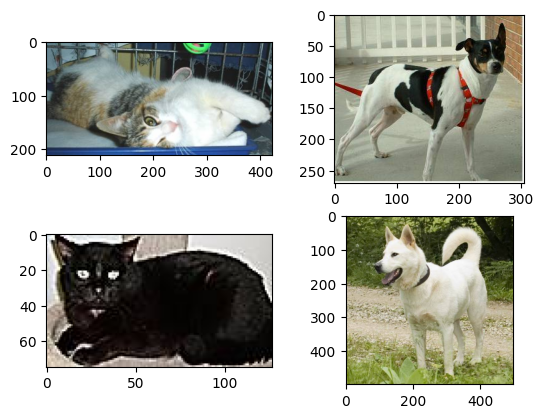

In [2]:
fig, axs = plt.subplots(2,2)
i=0
for root, dirs, files in os.walk("catsvsdogs"):
    if (len(files) <= 1):
        continue
    axs[int(i/2)][i%2].imshow(mpimg.imread(os.path.join(root, random.choice(files))))
    i+=1

Az *ImageDataGenerator* példányt felkonfiguráljuk: relatíve kis méretűre fogjuk a képeket átméretezni, $48 \times 48$-ra, ez alapján igyekszünk döntést hozni. Ez persze nem lesz egyszerű, de nagyobb méretű képek esetén a paraméterszám sokkal nagyobb lenne, így ezt a szempontot is figyelembe kell venni.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

imsize = 48

train_gen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

train_data = train_gen.flow_from_directory("catsvsdogs\\training_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           batch_size=16)

test_gen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

test_data = test_gen.flow_from_directory("catsvsdogs\\test_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           batch_size=16)

c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [4]:
param_num = imsize*imsize*3

from keras.models import Sequential
from keras.layers import Reshape, Dropout, Dense

model = Sequential()
model.add(Reshape((param_num, ), input_shape=(imsize, imsize, 3)))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(400, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(#optimizer='adam',
              optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 6912)              0         
                                                                 
 dense (Dense)               (None, 4000)              27652000  
                                                                 
 dropout (Dropout)           (None, 4000)              0         
                                                                 
 dense_1 (Dense)             (None, 4000)              16004000  
                                                                 
 dropout_1 (Dropout)         (None, 4000)              0         
                                                                 
 dense_2 (Dense)             (None, 400)               1600400   
                                                                 
 dropout_2 (Dropout)         (None, 400)               0

Egy egyszerű modellt alkottunk, a paraméterszám mégis hatalmas: ezt a nagy neuronszámú egymást követő teljesen összekötött rétegek okozzák.

In [6]:
from keras.callbacks import TensorBoard

tbcb = TensorBoard(log_dir="./logs/nemCNN")

In [7]:
model.fit_generator(train_data,
                    epochs=20,
                    validation_data=test_data,
                    callbacks=[tbcb]
                   )

C:\Users\dezsics\AppData\Local\Temp\ipykernel_27560\1109840961.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,
c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


FailedPreconditionError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} . is not a directory [Op:CreateSummaryFileWriter]

A tanítás összefoglalva:
- sokáig tart
- a modell lassan konvergál a globális optimum felé
- sokáig tart
- és tényleg nagyon sokáig tart

A tanítás lassúságát a nagy paraméterszám okozza, amely a nagy neuronszámú teljesen összekötött rétegek hatása.

A lassú konvergencia problémáját egyrészt az okozza hogy a bemeneti paraméterek között nem lát összefüggést a modell, miközben azok szomszédosan elhelyezkedő pixelek. A szomszédsági információt fel kellene használni! A probléma másik oldala a kis méretű kép, hiszen lekicsinyítést követően információt vesztettünk. Ha nagyobb méretű képeket használnánk, a paraméterek száma, és ezáltal a modell mérete is növekedne.